# TorchText
- [Torchtext](https://github.com/pytorch/text)
- based on https://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/


## Basic Formula for Transforming Data into Working Input for Neural Networks

Before you start training your model, you have to:

- Read the data from disk
- Tokenize the text
- Create a mapping from word to a unique integer
- Convert the text into lists of integers
- Load the data in whatever format your deep learning framework requires
- Pad the text so that all the sequences are the same length, so you can process them in batch

Torchtext is a library that makes all the above processing much easier.

## Overview

![](https://i2.wp.com/mlexplained.com/wp-content/uploads/2018/02/%E3%82%B9%E3%82%AF%E3%83%AA%E3%83%BC%E3%83%B3%E3%82%B7%E3%83%A7%E3%83%83%E3%83%88-2018-02-07-10.32.59.png?resize=1024%2C481&ssl=1)

- This document is based on the old version of TorchText.
- Please refer to Some Changes in current version.
- [Legacy](https://github.com/pytorch/text/tree/main/torchtext/legacy)

## Declaring the Fields

Torchtext takes a declarative approach to loading its data: you tell torchtext how you want the data to look like, and torchtext handles it for you.

The way you do this is by declaring a **Field**. The Field specifies how you want a certain (you guessed it) field to be processed.

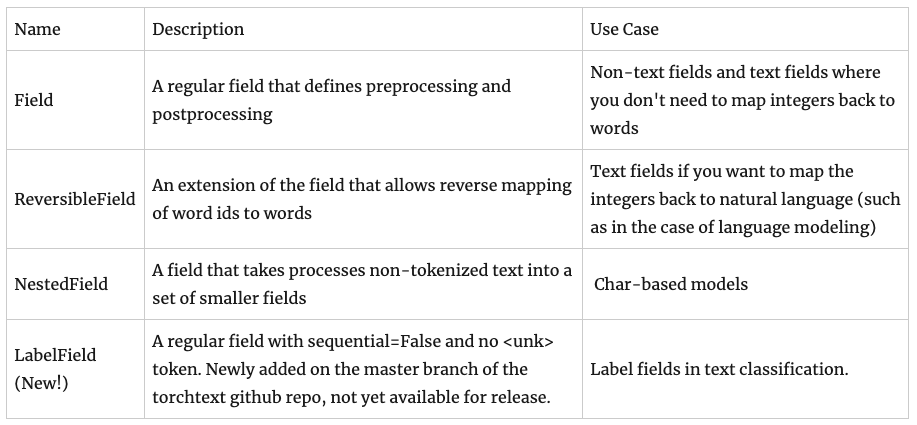

[The docstrings](https://github.com/pytorch/text/blob/c839a7934930819be7e240ea972e4d600966afdc/torchtext/data/field.py#L61) for the Field class are relativel well written

In [ ]:
## Examples

from torchtext.data import Field
tokenize = lambda x: x.split()
TEXT = Field(sequential=True, tokenize=tokenize, lower=True)

LABEL = Field(sequential=False, use_vocab=False)

## Constructing the Dataset

The fields know what to do when given raw data. Now, we need to tell the fields what data it should work on. This is where we use Datasets.

There are various built-in Datasets in torchtext that handle common data formats. For csv/tsv files, the TabularDataset class is convenient.

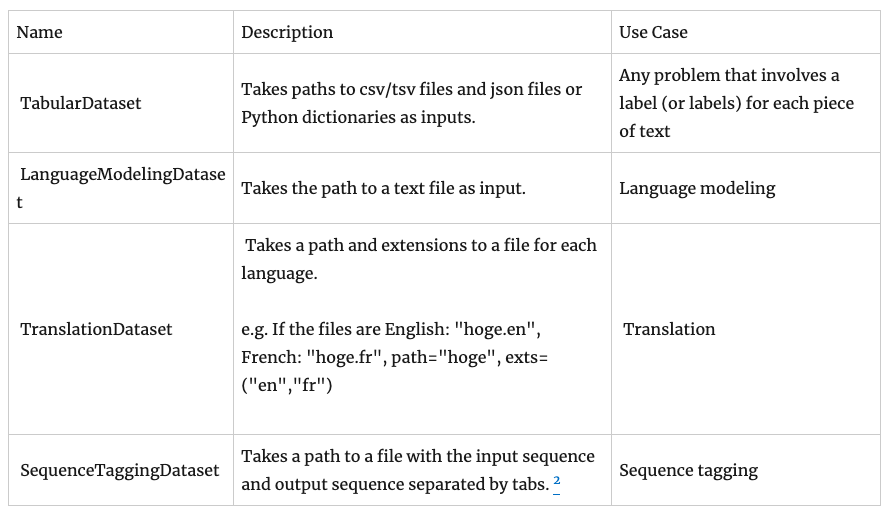

 Here's how we would read data from a csv file using the TabularDataset:

In [ ]:
## sample code

from torchtext.data import TabularDataset

raw_datafields = [("filename", None), # we won't be needing the filename, so we pass in None as the field
                 ("date", None), ("NewsPaper", None),
                 ("Topic", LABEL), ("News", TEXT)]

raw_data = data.TabularDataset(
        path='News_corpus_test.csv',
        format='csv',
        skip_header=True,
        fields=raw_datafields)

For the TabularDataset, we pass in a list of (name, field) pairs as the fields argument. The fields we pass in must be in the same order as the columns. For the columns we don't use, we pass in a tuple where the field element is None. 1

The splits method creates a dataset for the train and validation data by applying the same processing. It can also handle the test data, but since out test data has a different format from the train and validation data, we create a different dataset.

Torchtext handles mapping words to integers, but it has to be told the full range of words it should handle. In our case, we probably want to build the vocabulary on the training set only, so we run the following code:

In [ ]:
TEXT.build_vocab(trn)

## Constructing the Iterator

In torchvision and PyTorch, the processing and batching of data is handled by DataLoaders. For some reason, torchtext has renamed the objects that do the exact same thing to Iterators. The basic functionality is the same, but Iterators, as we will see, have some convenient functionality that is unique to NLP.

Below is code for how you would initialize the Iterators for the train, validation, and test data.

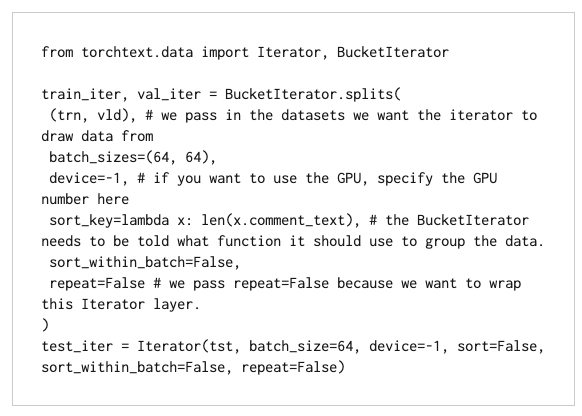

In [ ]:
## 우리 데이터에서

BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, test_data), sort_key=lambda x: len(x.News),
    sort_within_batch=False,repeat=False,
    batch_size = BATCH_SIZE,
    device = device)

The BucketIterator is one of the most powerful features of torchtext. It automatically shuffles and buckets the input sequences into sequences of similar length.

The reason this is powerful is that - as I mentioned earlier - we need to pad the input sequences to be of the same length to enable batch processing. For instance, the sequences

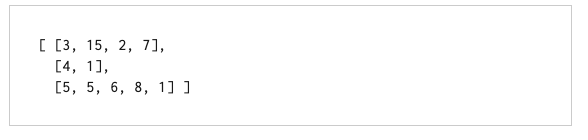
  
would need to be padded to become

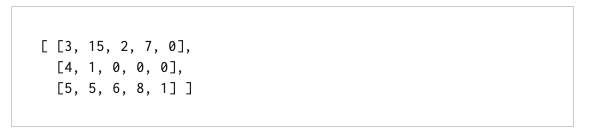

As you can see, the amount of padding necessary is determined by the longest sequence in the batch. Therefore, padding is most efficient when the sequences are of similar lengths. The BucketIterator does all this behind the scenes. As a word of caution, you need to tell the BucketIterator what attribute you want to bucket the data on

For the test data, we don't want to shuffle the data since we'll be outputting the predictions at the end of training. This is why we use a standard iterator.

## Example Without torchtext for user input

- Torchtext를 사용하지 않을 경우 데이터를 Pytorch로 학습하고 테스트하기 위해 필요한 데이터 준비, 로딩 등을 구현

### Preparing Data

In [9]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data
import konlpy
from konlpy.tag import Mecab

In [10]:
data_path = "News_corpus_test.csv"

dataframe = pd.read_csv(data_path, sep = ',')
print('[Info] Get {} data from {}'.format(len(dataframe), data_path))
dataframe = dataframe.dropna(how='any')
print('[Info] Drop null data, now the length of this data is {}'.format(len(dataframe)))

dataframe['Topic'] = dataframe['Topic'].replace(['정치', '경제', '사회', '생활', '문화', '스포츠','IT/과학', '미용/건강', '연예' ], [0, 1, 2, 3, 4, 5, 6, 7, 8])
dataframe = dataframe.sample(frac = 1) 
dataframe.head(10)

[Info] Get 1800 data from News_corpus_test.csv
[Info] Drop null data, now the length of this data is 1800


,filename,date,NewsPaper,Topic,News
998,NPRW1900000003,20110306,한국경제신문사,2,"<p> 인권 사이트 ""대학생들 재스민 시위 참여하자""…공안 철통경계로 무산 </p>..."
1721,NLRW1900000140,20160504,부산일보,0,<p> 새누리 원내대표 3일 경선… 친박 '이러지도 저러지도' </p> <p> 새누...
1266,NPRW1900000040,20180105,내일신문,5,<p> 평창 동계패럴림픽 입장권 판매율 50% 넘어 </p> <p> 2018 평창 ...
125,NPRW1900000059,20170410,매일경제신문사,6,<p> 갤S8 `돌풍` 무섭네…이틀새 55만대 예약 </p> <p> 삼성전자 갤럭시...
277,NLRW1900000090,20161011,국제신문,1,"<p> 기업활력법 사업재편, 철강업계서도 첫 신청 </p> <p> - 연내 10~1..."
1108,NWRW1900000028,20161118,동아일보사,3,<p> 식사는 정차하는 역에서 해결하는 것이 좋아요 </p> <p> ■ 여행 팁 <...
1550,NWRW1900000004,20121121,조선일보사,8,<p> 항공기 승무원·무속인·치킨집 사장… A부터 Z까지 풀어내는 그들의 직업 </...
475,NPRW1900000035,20130125,내일신문,4,"<p> 뮤지컬 ‘The Promise’, 찬사속에 종료 </p> <p> 정전 60주..."
1378,NWRW1900000054,20120529,한겨레,5,<p> ‘사흘 천하’…속타는 감독 </p> <p> 혼돈의 시대가 도래했다. 중간순위...
178,NWRW1900000060,20180213,한겨레,6,<p> $(지면은 보류)/19면/디출 말것/마이크로 LED </p> <p> QLED...


In [11]:
def tokenizer(string):
    string.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    mecab = Mecab()
#     return mecab.morphs(string)
    nouns= mecab.nouns(string)
    nouns = [a for a in nouns if len(a) >1]
    return nouns

def apply_tokenizer(dataframe):
    print('[Info] Tokenize...')
    return dataframe.apply(tokenizer).tolist()

sentence, label = apply_tokenizer(dataframe['News']), dataframe['Topic'].tolist()

[Info] Tokenize...


In [14]:
def build_vocab(sentence):
    print('[Info] Build vocabulary')
    vocab_set = set(token for sent in sentence for token in sent)

    vocab = { "<pad>": 0, "<unk>": 1}
    start_index = len(vocab)
    for i, token in enumerate(vocab_set):
        vocab[token] = start_index + i    
    return vocab

def vectorize(vocab, sentences, one_sentence=False):
    UNK = vocab.get('<unk>')
    if one_sentence:
        return [vocab.get(token, UNK) for token in sentences]
    return [[vocab.get(token, UNK) for token in sent] for sent in sentences]

vocab = build_vocab(sentence)
print('[Info] Vocabulary size=', len(vocab))
vec_sentence = vectorize(vocab, sentence)
print (vec_sentence[0])

[Info] Build vocabulary
[Info] Vocabulary size= 27424
[12318, 10668, 24183, 26420, 2771, 4735, 23960, 26380, 15275, 22981, 20231, 16732, 20829, 12415, 18791, 7243, 7531, 17553, 7850, 14772, 26369, 26420, 2771, 11388, 26495, 18791, 13997, 14772, 10772, 12460, 19529, 18100, 14956, 4595, 18371, 4579, 18100, 12472, 7695, 7850, 22788, 14566, 3589, 9376, 17332, 26219, 18791, 3979, 26207, 10592, 24278, 22022, 19533, 13809, 12318, 10319, 17879, 10668, 18791, 10647, 13374, 20231, 13997, 19033, 7531, 12460, 9965, 26420, 24278, 4735, 11750, 9354, 18791, 7531, 12460, 7850, 12794, 11062, 9416, 13359, 15717, 2771, 15569, 5284, 5091, 7332, 14840, 14772, 10772, 19863, 5576, 5980, 5320, 11718, 24278, 1857, 14422, 6471, 18100, 8582, 2158, 12454, 10720, 13924, 18100, 4078, 11062, 25056, 20231, 18100, 18771, 16732, 3979, 19255, 5167, 17099, 23739, 15630, 18100, 4595, 18371, 18523, 24278, 3873, 24127, 7164, 4162, 18247, 20231, 10397, 11117, 16566, 24138, 26524, 14138, 4603, 15009, 27202, 14606, 26369, 2574

In [15]:
split_ratio = 0.8

n_split = int(len(sentence) * split_ratio)
trn_sentence, trn_label = vec_sentence[:n_split], label[:n_split]
val_sentence, val_label = vec_sentence[n_split:], label[n_split:]
print('[Info] Split {} data to {} for train data,  {} for valid data.'.format(len(vec_sentence), len(trn_sentence), len(val_sentence)))

[Info] Split 1800 data to 1440 for train data,  360 for valid data.


In [16]:
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, sentence, label):
        self.vocab = vocab
        self.sentence = sentence
        self.label = label

    def __len__(self):
        return len(self.sentence)
    
    def __getitem__(self, idx):
        sentence = torch.LongTensor(self.sentence[idx])
        label = torch.LongTensor([self.label[idx]])
        return sentence, label

train_dataset, valid_dataset = NewsDataset(vocab, trn_sentence, trn_label), NewsDataset(vocab, val_sentence, val_label)
print('[Info] Build train and valid dataset')

[Info] Build train and valid dataset


In [17]:
print(f'Number of training examples: {len(train_dataset)}')
print(f'Number of valid examples: {len(valid_dataset)}')

Number of training examples: 1440
Number of valid examples: 360


## Build data iterator

In [18]:
def padding(inputs): 
    sentence, label = list(zip(*inputs))
    sentence = torch.nn.utils.rnn.pad_sequence(sentence, batch_first=True, padding_value=0)
    batch =  [ sentence, torch.cat(label, dim=0) ]
    return batch

In [19]:
BATCH_SIZE = 128

train_iterator = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=padding)
valid_iterator = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=padding)

## Build RNN Model

In [20]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout, batch_first=True)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [batch size, sent len]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [batch size, sent len, emb dim]
        
        output, (hidden, cell) = self.rnn(embedded)
        
        #output = [batch size, sent len, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [batch size, num layers * num directions, hid dim]
        #cell = [batch size, num layers * num directions, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden)

In [21]:
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 9
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = vocab["<pad>"]

In [22]:
model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,057,161 trainable parameters


In [24]:
UNK_IDX = vocab["<unk>"]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

## Train the Model

In [25]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

model = model.to(device)

In [27]:
from tqdm import tqdm

def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    correct = 0
    total = 0
    
    model.train()
    
    for batch_sentence, batch_label in tqdm(iterator):
        batch_sentence = batch_sentence.to(device)
        batch_label = batch_label.to(device)
        
        optimizer.zero_grad()
                
        outputs = model(batch_sentence)
        loss = criterion(outputs, batch_label)
        _, predicted = torch.max(outputs.data, 1)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        total += batch_label.size(0)
        correct += (predicted == batch_label).sum().item()
        
    return epoch_loss , correct / total

In [28]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    correct = 0
    total = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch_sentence, batch_label in tqdm(iterator):
            batch_sentence = batch_sentence.to(device)
            batch_label = batch_label.to(device)
            
            outputs = model(batch_sentence)
       
            loss = criterion(outputs, batch_label)
            _, predicted = torch.max(outputs.data, 1)
            
            epoch_loss += loss.item()
            total += batch_label.size(0)
            correct += (predicted == batch_label).sum().item()
        
    return epoch_loss , correct / total

In [29]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [30]:
N_EPOCHS = 50

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 2s
	Train Loss: 26.376 | Train Acc: 11.11%
	 Val. Loss: 6.591 |  Val. Acc: 8.89%


  8%|▊         | 1/12 [00:00<00:01,  9.39it/s]

Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 26.142 | Train Acc: 16.18%
	 Val. Loss: 6.575 |  Val. Acc: 15.83%


 17%|█▋        | 2/12 [00:00<00:00, 10.36it/s]

Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 25.772 | Train Acc: 22.43%
	 Val. Loss: 6.478 |  Val. Acc: 19.72%


  8%|▊         | 1/12 [00:00<00:01,  9.03it/s]

Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 24.622 | Train Acc: 25.28%
	 Val. Loss: 6.292 |  Val. Acc: 23.33%


  8%|▊         | 1/12 [00:00<00:01,  8.97it/s]

Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 22.928 | Train Acc: 31.81%
	 Val. Loss: 6.009 |  Val. Acc: 26.94%


  8%|▊         | 1/12 [00:00<00:01,  9.18it/s]

Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 21.468 | Train Acc: 38.61%
	 Val. Loss: 6.922 |  Val. Acc: 27.22%


  8%|▊         | 1/12 [00:00<00:01,  8.31it/s]

Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 23.009 | Train Acc: 32.64%
	 Val. Loss: 6.100 |  Val. Acc: 28.61%


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 21.349 | Train Acc: 37.85%
	 Val. Loss: 5.851 |  Val. Acc: 35.83%


  8%|▊         | 1/12 [00:00<00:01,  9.60it/s]

Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 20.665 | Train Acc: 40.21%
	 Val. Loss: 6.427 |  Val. Acc: 29.17%


  8%|▊         | 1/12 [00:00<00:01,  9.09it/s]

Epoch: 10 | Epoch Time: 0m 1s
	Train Loss: 19.213 | Train Acc: 45.00%
	 Val. Loss: 10.399 |  Val. Acc: 16.11%


 17%|█▋        | 2/12 [00:00<00:00, 10.15it/s]

Epoch: 11 | Epoch Time: 0m 1s
	Train Loss: 17.932 | Train Acc: 48.61%
	 Val. Loss: 5.396 |  Val. Acc: 40.56%


  8%|▊         | 1/12 [00:00<00:01,  9.03it/s]

Epoch: 12 | Epoch Time: 0m 1s
	Train Loss: 16.672 | Train Acc: 52.43%
	 Val. Loss: 5.100 |  Val. Acc: 40.83%


  8%|▊         | 1/12 [00:00<00:01,  8.64it/s]

Epoch: 13 | Epoch Time: 0m 1s
	Train Loss: 15.308 | Train Acc: 55.49%
	 Val. Loss: 5.607 |  Val. Acc: 40.83%


  8%|▊         | 1/12 [00:00<00:01,  9.30it/s]

Epoch: 14 | Epoch Time: 0m 1s
	Train Loss: 14.414 | Train Acc: 58.06%
	 Val. Loss: 6.193 |  Val. Acc: 36.11%


 17%|█▋        | 2/12 [00:00<00:00, 10.24it/s]

Epoch: 15 | Epoch Time: 0m 1s
	Train Loss: 14.182 | Train Acc: 61.81%
	 Val. Loss: 5.723 |  Val. Acc: 42.50%


  8%|▊         | 1/12 [00:00<00:01,  9.25it/s]

Epoch: 16 | Epoch Time: 0m 1s
	Train Loss: 13.404 | Train Acc: 61.18%
	 Val. Loss: 9.428 |  Val. Acc: 30.83%


  8%|▊         | 1/12 [00:00<00:01,  9.35it/s]

Epoch: 17 | Epoch Time: 0m 1s
	Train Loss: 13.013 | Train Acc: 63.47%
	 Val. Loss: 6.219 |  Val. Acc: 45.28%


  8%|▊         | 1/12 [00:00<00:01,  9.16it/s]

Epoch: 18 | Epoch Time: 0m 1s
	Train Loss: 12.494 | Train Acc: 64.31%
	 Val. Loss: 5.952 |  Val. Acc: 44.44%


  8%|▊         | 1/12 [00:00<00:01,  8.97it/s]

Epoch: 19 | Epoch Time: 0m 1s
	Train Loss: 12.057 | Train Acc: 66.53%
	 Val. Loss: 5.483 |  Val. Acc: 45.00%


 17%|█▋        | 2/12 [00:00<00:00, 10.26it/s]

Epoch: 20 | Epoch Time: 0m 1s
	Train Loss: 11.216 | Train Acc: 67.85%
	 Val. Loss: 5.586 |  Val. Acc: 44.72%


  8%|▊         | 1/12 [00:00<00:01,  8.88it/s]

Epoch: 21 | Epoch Time: 0m 1s
	Train Loss: 10.796 | Train Acc: 70.49%
	 Val. Loss: 5.808 |  Val. Acc: 44.17%


  8%|▊         | 1/12 [00:00<00:01,  9.22it/s]

Epoch: 22 | Epoch Time: 0m 1s
	Train Loss: 10.403 | Train Acc: 71.88%
	 Val. Loss: 5.400 |  Val. Acc: 51.39%


  8%|▊         | 1/12 [00:00<00:01,  8.32it/s]

Epoch: 23 | Epoch Time: 0m 1s
	Train Loss: 8.818 | Train Acc: 74.79%
	 Val. Loss: 5.644 |  Val. Acc: 51.39%


  8%|▊         | 1/12 [00:00<00:01,  8.29it/s]

Epoch: 24 | Epoch Time: 0m 1s
	Train Loss: 9.325 | Train Acc: 74.03%
	 Val. Loss: 6.038 |  Val. Acc: 46.39%


 17%|█▋        | 2/12 [00:00<00:00, 10.70it/s]

Epoch: 25 | Epoch Time: 0m 1s
	Train Loss: 9.090 | Train Acc: 75.00%
	 Val. Loss: 7.032 |  Val. Acc: 43.61%


  8%|▊         | 1/12 [00:00<00:01,  9.45it/s]

Epoch: 26 | Epoch Time: 0m 1s
	Train Loss: 9.248 | Train Acc: 75.07%
	 Val. Loss: 5.477 |  Val. Acc: 49.17%


  8%|▊         | 1/12 [00:00<00:01,  8.78it/s]

Epoch: 27 | Epoch Time: 0m 1s
	Train Loss: 7.822 | Train Acc: 78.19%
	 Val. Loss: 5.421 |  Val. Acc: 52.22%


 17%|█▋        | 2/12 [00:00<00:00, 10.53it/s]

Epoch: 28 | Epoch Time: 0m 1s
	Train Loss: 6.385 | Train Acc: 81.88%
	 Val. Loss: 5.907 |  Val. Acc: 51.39%


  8%|▊         | 1/12 [00:00<00:01,  8.29it/s]

Epoch: 29 | Epoch Time: 0m 1s
	Train Loss: 6.400 | Train Acc: 82.43%
	 Val. Loss: 5.791 |  Val. Acc: 52.78%


  8%|▊         | 1/12 [00:00<00:01,  9.47it/s]

Epoch: 30 | Epoch Time: 0m 1s
	Train Loss: 5.863 | Train Acc: 85.14%
	 Val. Loss: 5.132 |  Val. Acc: 56.39%


  8%|▊         | 1/12 [00:00<00:01,  8.60it/s]

Epoch: 31 | Epoch Time: 0m 1s
	Train Loss: 5.560 | Train Acc: 84.24%
	 Val. Loss: 5.518 |  Val. Acc: 54.17%


  8%|▊         | 1/12 [00:00<00:01,  9.01it/s]

Epoch: 32 | Epoch Time: 0m 1s
	Train Loss: 4.818 | Train Acc: 86.74%
	 Val. Loss: 5.730 |  Val. Acc: 56.39%


  8%|▊         | 1/12 [00:00<00:01,  8.91it/s]

Epoch: 33 | Epoch Time: 0m 1s
	Train Loss: 4.361 | Train Acc: 87.99%
	 Val. Loss: 6.331 |  Val. Acc: 55.56%


 17%|█▋        | 2/12 [00:00<00:00, 10.12it/s]

Epoch: 34 | Epoch Time: 0m 1s
	Train Loss: 4.627 | Train Acc: 87.43%
	 Val. Loss: 6.735 |  Val. Acc: 53.89%


 17%|█▋        | 2/12 [00:00<00:00, 10.23it/s]

Epoch: 35 | Epoch Time: 0m 1s
	Train Loss: 4.299 | Train Acc: 87.64%
	 Val. Loss: 7.292 |  Val. Acc: 50.83%


  8%|▊         | 1/12 [00:00<00:01,  9.21it/s]

Epoch: 36 | Epoch Time: 0m 1s
	Train Loss: 4.456 | Train Acc: 88.33%
	 Val. Loss: 6.420 |  Val. Acc: 52.50%


  8%|▊         | 1/12 [00:00<00:01,  9.72it/s]

Epoch: 37 | Epoch Time: 0m 1s
	Train Loss: 4.970 | Train Acc: 86.11%
	 Val. Loss: 8.642 |  Val. Acc: 47.22%


  8%|▊         | 1/12 [00:00<00:01,  9.35it/s]

Epoch: 38 | Epoch Time: 0m 1s
	Train Loss: 7.291 | Train Acc: 80.21%
	 Val. Loss: 5.791 |  Val. Acc: 50.56%


  8%|▊         | 1/12 [00:00<00:01,  9.37it/s]

Epoch: 39 | Epoch Time: 0m 1s
	Train Loss: 5.197 | Train Acc: 85.83%
	 Val. Loss: 8.005 |  Val. Acc: 46.11%


  8%|▊         | 1/12 [00:00<00:01,  9.89it/s]

Epoch: 40 | Epoch Time: 0m 1s
	Train Loss: 4.778 | Train Acc: 87.78%
	 Val. Loss: 6.972 |  Val. Acc: 51.94%


  8%|▊         | 1/12 [00:00<00:01,  8.95it/s]

Epoch: 41 | Epoch Time: 0m 1s
	Train Loss: 5.290 | Train Acc: 86.60%
	 Val. Loss: 6.080 |  Val. Acc: 52.50%


  8%|▊         | 1/12 [00:00<00:01,  9.11it/s]

Epoch: 42 | Epoch Time: 0m 1s
	Train Loss: 5.053 | Train Acc: 86.18%
	 Val. Loss: 7.104 |  Val. Acc: 50.56%


 17%|█▋        | 2/12 [00:00<00:00, 10.46it/s]

Epoch: 43 | Epoch Time: 0m 1s
	Train Loss: 4.431 | Train Acc: 88.26%
	 Val. Loss: 6.340 |  Val. Acc: 51.94%


 17%|█▋        | 2/12 [00:00<00:00, 10.91it/s]

Epoch: 44 | Epoch Time: 0m 1s
	Train Loss: 3.897 | Train Acc: 91.18%
	 Val. Loss: 7.246 |  Val. Acc: 51.39%


  8%|▊         | 1/12 [00:00<00:01,  8.96it/s]

Epoch: 45 | Epoch Time: 0m 1s
	Train Loss: 3.036 | Train Acc: 92.43%
	 Val. Loss: 6.298 |  Val. Acc: 58.33%


  8%|▊         | 1/12 [00:00<00:01,  9.40it/s]

Epoch: 46 | Epoch Time: 0m 1s
	Train Loss: 2.798 | Train Acc: 93.12%
	 Val. Loss: 7.294 |  Val. Acc: 55.00%


  8%|▊         | 1/12 [00:00<00:01,  9.35it/s]

Epoch: 47 | Epoch Time: 0m 1s
	Train Loss: 3.011 | Train Acc: 91.32%
	 Val. Loss: 6.309 |  Val. Acc: 56.39%


  8%|▊         | 1/12 [00:00<00:01,  9.21it/s]

Epoch: 48 | Epoch Time: 0m 1s
	Train Loss: 2.688 | Train Acc: 92.92%
	 Val. Loss: 11.424 |  Val. Acc: 42.78%


  8%|▊         | 1/12 [00:00<00:01,  8.97it/s]

Epoch: 49 | Epoch Time: 0m 1s
	Train Loss: 3.621 | Train Acc: 91.11%
	 Val. Loss: 7.402 |  Val. Acc: 54.72%


100%|██████████| 3/3 [00:00<00:00, 30.75it/s]

Epoch: 50 | Epoch Time: 0m 1s
	Train Loss: 3.104 | Train Acc: 91.60%
	 Val. Loss: 5.688 |  Val. Acc: 56.11%


## Example With torchtext for user input

### Try Yourself!